In [1]:
import os
import sys
import csv
import numpy as np
from typing import Literal
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Add the path to the custom library to the system path
sys.path.append('..')

# Import the module from the custom library
from src.architectures.auto_regressive import AutoRegressive
from src.core.utils import data_analysis, data_processing, context_manager
from src import Tensor, layers, loss_functions, optimizers, metrics, callbacks

### Constants and Hyperparameters

In [2]:
# Path to where the model will be saved
model_path = os.path.join(os.getcwd(), 'checkpoints', 'stock_prediction_rnn')
dataset_path = os.path.join(os.getcwd(), 'dataset', 'SPX.csv')

# Define the feature and target columns
feature_columns = ['Open', 'High', 'Low', 'Close']
close_price_idx = feature_columns.index('Close')

In [3]:
# Hyperparameters for the model
normalization: Literal['minmax', 'standard'] = 'standard'
train_test_split_pct = 0.05
train_valid_split_pct = 0.1
learning_rate = 3e-4
batch_size = 64
epochs = 50
seq_len = 24
seed = 1234

# Volatility prediction settings
predict_volatility = True
volatility_window = 5

In [4]:
# Set the seed for reproducibility
np.random.seed(seed)

### Data loading

In [5]:
def load_data(file_path: str) -> list[dict]:
    """
    Load data from a CSV file with proper date parsing.
    
    Parameters:
    - file_path: str, path to the CSV file
    
    Returns:
    - data: list[dict], list of dictionaries containing the data
    """
    
    # Create a list to hold the data
    data = []
    
    # Open the CSV file and read its contents
    with open(file_path, 'r') as file:
        # Use DictReader to read the CSV file into a list of dictionaries
        reader = csv.DictReader(file)
        
        # Iterate over each row in the CSV file
        for row in reader:
            # Ensure the 'Date' field is in the correct format
            try:
                # Parse the date and convert it to a datetime object
                datetime.strptime(row['Date'], '%Y-%m-%d')
                
                # Add the row to the data list
                data.append(row)
                
            except ValueError:
                # If the date is invalid, skip this row
                print(f"Skipping row with invalid date: {row['Date']}")
                continue
    
    # Sort the data by date
    data.sort(key=lambda x: x['Date'])
    
    # return the loaded and sorted data
    return data

In [6]:
# Load the data
data = load_data(dataset_path)

# Print the number of data points and the date range
print(f"Loaded {len(data)} data points")
print(f"Date range: {data[0]['Date']} to {data[-1]['Date']}")

Loaded 23323 data points
Date range: 1927-12-30 to 2020-11-04


In [7]:
# Extract the feature and timestamp data
features = np.array([[np.float32(data[j][k]) for k in feature_columns] for j in range(len(data))])
timestamps = np.array([datetime.strptime(data[j]['Date'], '%Y-%m-%d').timestamp() for j in range(len(data))], dtype=np.int32)

# Print the shapes of the features and dates arrays
print(f"Price data shape: {features.shape}")
print(f"Timestamps shape: {timestamps.shape}")

Price data shape: (23323, 4)
Timestamps shape: (23323,)


### Features engineering

In [8]:
def compute_log_returns(prices: np.ndarray) -> np.ndarray:
    """
    Calculate log returns: ln(P_t / P_{t-1})
    
    Parameters:
    - prices: np.ndarray, absolute prices with shape (T, F)
    
    Returns:
    - log_returns: np.ndarray, log returns with shape (T-1, F)
    """
    
    # Compute log returns using the formula ln(P_t / P_{t-1})
    return np.log(prices[1:] / prices[:-1])


def compute_realized_volatility(log_returns: np.ndarray, window: int) -> np.ndarray:
    """
    Calculate realized volatility using rolling window of squared returns.
    
    Parameters:
    - log_returns: np.ndarray, log returns with shape (T, F)
    - window: int, rolling window size
    
    Returns:
    - volatility: np.ndarray, realized volatility
    """
    
    # Compute squared log returns
    squared_returns = log_returns ** 2
    
    # Initialize an empty list to hold the volatility values
    volatility = []
    
    # Iterate over the log returns with a rolling window
    for i in range(window, len(squared_returns)):
        # Calculate the volatility as the square root of the mean of squared returns
        vol = np.sqrt(np.mean(squared_returns[i-window:i], axis=0))
        
        # Append the calculated volatility to the list
        volatility.append(vol)
    
    # Convert the list to a numpy array and return
    return np.array(volatility)

In [9]:
# Compute log returns
log_returns = compute_log_returns(features)
timestamps_returns = timestamps[1:]

# Print the shape and statistics of the log returns
print(f"Log returns shape: {log_returns.shape}")
print(f"Log returns stats - Mean: {np.mean(log_returns, axis=0)}")
print(f"Log returns stats - Std: {np.std(log_returns, axis=0)}")

# Compute realized volatility if required
if predict_volatility:
    # Compute realized volatility using a rolling window
    realized_volatility = compute_realized_volatility(log_returns, volatility_window)
    
    # Adjust timestamp for the volatility data
    timestamps_volatility = timestamps_returns[volatility_window:]
    
    # Print the shape and statistics of the realized volatility
    print(f"Realized volatility shape: {realized_volatility.shape}")

Log returns shape: (23322, 4)
Log returns stats - Mean: [0.00022563 0.00022662 0.00022561 0.00022609]
Log returns stats - Std: [0.01179839 0.01105997 0.01168979 0.01202147]
Realized volatility shape: (23317, 4)


### Data preprocessing

In [10]:
# Set the target data based on whether we are predicting volatility or log returns
if predict_volatility:
    # Use realized volatility as target data
    target_data = realized_volatility
    input_data = log_returns[volatility_window:] 
    input_timestamps = timestamps_volatility
    
else:
    # Use log returns as target data
    target_data = log_returns
    input_data = log_returns
    input_timestamps = timestamps_returns

# Perform the temporal split
print(f"Target data shape: {target_data.shape}")
print(f"Input data shape: {input_data.shape}")
print(f"Input timestamps shape: {input_timestamps.shape}")

Target data shape: (23317, 4)
Input data shape: (23317, 4)
Input timestamps shape: (23317,)


In [11]:
def build_sequences(input_data: np.ndarray, target_data: np.ndarray, timestamps: np.ndarray, seq_length: int) -> tuple[Tensor, Tensor, Tensor]:
    """
    Build sequences
    
    Parameters:
    - input_data: np.ndarray, input features
    - target_data: np.ndarray, target values (aligned with input_data)
    - timestamps: np.ndarray, timestamps corresponding to input_data
    - seq_length: int, length of input sequences
    
    Returns:
    - tuple[Tensor, Tensor, Tensor]: input sequences, target values, and timestamps as Tensors
    """
    
    # Initialize lists to hold sequences and targets
    X, y, ts = [], [], []
    
    # Iterate over the input data to create sequences
    for i in range(seq_length, len(input_data)):
        # Append the sequence of input and the corresponding target
        X.append(input_data[i-seq_length:i])
        y.append(target_data[i])
        ts.append(timestamps[i])
    
    # Convert the lists to numpy arrays and return as Tensors
    return (
        Tensor(np.array(X, dtype=np.float32)),
        Tensor(np.array(y, dtype=np.float32)),
        Tensor(np.array(ts, dtype=np.int32))
    )

In [12]:
# Build sequences
features, targets, sequence_timestamps = build_sequences(input_data, target_data, input_timestamps, seq_len)

# Print the shapes of the features and targets
print(f"Features shape: {features.shape()}")
print(f"Targets shape: {targets.shape()}")
print(f"Timestamps shape: {sequence_timestamps.shape()}")

Features shape: (23293, 24, 4)
Targets shape: (23293, 4)
Timestamps shape: (23293,)


### Data splitting

In [13]:
# Split the dataset into training, validation, and testing sets
(X_train, X_test, y_train, y_test), train_test_shuffle_indices = data_processing.split_data((features, targets), train_test_split_pct, shuffle=True)
(X_train, X_valid, y_train, y_valid), train_valid_shuffle_indices = data_processing.split_data((X_train, y_train), train_valid_split_pct, shuffle=True)

# Ensure the shuffle indices are numpy arrays
assert isinstance(train_test_shuffle_indices, np.ndarray), "train_test_shuffle_indices should be a numpy array"
assert isinstance(train_valid_shuffle_indices, np.ndarray), "train_valid_shuffle_indices should be a numpy array"

# Extract the timestamps for each set
train_timestamps, test_timestamps = data_processing.split_data(sequence_timestamps[train_test_shuffle_indices], train_test_split_pct, shuffle=False)[0]
train_timestamps, valid_timestamps = data_processing.split_data(train_timestamps[train_valid_shuffle_indices], train_valid_split_pct, shuffle=False)[0]

# Print the dataset information
print('Training set:', X_train.shape(), y_train.shape())
print('Validation set:', X_valid.shape(), y_valid.shape())
print('Testing set:', X_test.shape(), y_test.shape())

Training set: (19917, 24, 4) (19917, 4)
Validation set: (2212, 24, 4) (2212, 4)
Testing set: (1164, 24, 4) (1164, 4)


### Data normalization

In [14]:
# Compute normalization statistics from training data only
mean, std, min, max = data_processing.compute_stats(X=X_train, axis=(0, 1))

# Print the normalization statistics
print('Normalization statistics (from training data only):')
print('Min:', min.to_numpy())
print('Max:', max.to_numpy())
print('Mean:', mean.to_numpy())
print('Std:', std.to_numpy())

Normalization statistics (from training data only):
Min: [-0.2280193  -0.14060071 -0.22485887 -0.22899728]
Max: [0.1536613 0.1536613 0.1536613 0.1536613]
Mean: [0.00022591 0.00022727 0.00022507 0.00022662]
Std: [0.01183559 0.01109752 0.01172912 0.01206009]


In [15]:
# Define normalization functions based on the normalization method
def normalization_fn(x: Tensor) -> Tensor:
    """
    Normalize input data based on the specified normalization method.
    
    Parameters:
    - x: Tensor, input data to normalize
    
    Returns:
    - Tensor, normalized data
    """
    
    if normalization == 'minmax':
        # Normalize using Min-Max normalization
        return data_processing.min_max_normalize(x, min, max)
    else:
        # Normalize using Z-score normalization
        return data_processing.z_score_normalize(x, mean, std)


# Define denormalization functions based on the normalization method
def denormalization_fn(x: Tensor) -> Tensor:
    """
    Denormalize input data based on the specified normalization method.
    
    Parameters:
    - x: Tensor, normalized data to denormalize
    
    Returns:
    - Tensor, denormalized data
    """
    
    if normalization == 'minmax':
        # Denormalize using Min-Max normalization
        return data_processing.min_max_denormalize(x, min, max)
    else:
        # Denormalize using Z-score normalization
        return data_processing.z_score_denormalize(x, mean, std)

In [16]:
# Normalize the training, validation, and test sets using training statistics
X_train_norm = normalization_fn(X_train)
X_valid_norm = normalization_fn(X_valid)
X_test_norm = normalization_fn(X_test)

# Normalize the target variable using the computed statistics
y_train_norm = normalization_fn(y_train)
y_valid_norm = normalization_fn(y_valid)

### Building the model

In [17]:
# Define the model architecture
model = AutoRegressive(
    name = "Stock prediction model",
    sequence_length = seq_len,
    input_type = 'continuous',
    modules = [
        layers.RNN(num_layers=2, num_units=64, dropout=0.3),
        layers.Dense(num_units=32),
        layers.Dropout(0.3),
        layers.Dense(num_units=y_train.shape()[-1])
    ]
)

# Initialize the optimizer with lower learning rate
optimizer = optimizers.Adam(learning_rate=learning_rate)

# Initialize the loss function
loss_fn = loss_functions.MeanSquareError()

### Initializing the model

In [18]:
# Call the model with a first batch to initialize the weights
# This is not necessary, but it is useful to know the input size

# Disable gradient computation
with context_manager.no_grad():
    # Set the model in evaluation mode
    model.eval()
    
    # Call the model with a batch of data to initialize it
    model(X_train_norm[:batch_size])

In [19]:
# Display model summary
model.summary(recursive=True)

Stock prediction model (AutoRegressive) [output_shape=(64, 4), params=15012]
└── stock_prediction_model.modules (ModuleList) [output_shape=(64, 4), params=15012]
    ├── module_list.0 (RNN) [output_shape=(64, 64), params=12800]
    │   └── rnn.dropout_layer (Dropout) [output_shape=(64, 64), params=0]
    ├── module_list.1 (Dense) [output_shape=(64, 32), params=2080]
    ├── module_list.2 (Dropout) [output_shape=(64, 32), params=0]
    └── module_list.3 (Dense) [output_shape=(64, 4), params=132]


### Training the model

In [20]:
# Training with early stopping
history = model.fit(
    X_train = X_train_norm,
    y_train = y_train_norm,
    X_valid = X_valid_norm,
    y_valid = y_valid_norm,
    epochs = epochs,
    loss_fn = loss_fn,
    optimizer = optimizer,
    batch_size = batch_size,
    metrics = [metrics.mean_absolute_error],
    callbacks = [callbacks.EarlyStopping(monitor='val_loss', patience=10)]
)

Epoch 1/50 --> loss: 0.57209 - mean absolute error: 0.49779 | Valid loss: 0.30043 - Valid mean absolute error: 0.37587             
Epoch 2/50 --> loss: 0.2894 - mean absolute error: 0.34384 | Valid loss: 0.17186 - Valid mean absolute error: 0.28891             
Epoch 3/50 --> loss: 0.19567 - mean absolute error: 0.2916 | Valid loss: 0.13906 - Valid mean absolute error: 0.26127             
Epoch 4/50 --> loss: 0.15898 - mean absolute error: 0.26355 | Valid loss: 0.11 - Valid mean absolute error: 0.21529             
Epoch 5/50 --> loss: 0.13906 - mean absolute error: 0.24733 | Valid loss: 0.10575 - Valid mean absolute error: 0.21389             
Epoch 6/50 --> loss: 0.12082 - mean absolute error: 0.23307 | Valid loss: 0.079527 - Valid mean absolute error: 0.18139             
Epoch 7/50 --> loss: 0.11451 - mean absolute error: 0.22572 | Valid loss: 0.067188 - Valid mean absolute error: 0.16488             
Epoch 8/50 --> loss: 0.10597 - mean absolute error: 0.21659 | Valid loss: 0.063

In [21]:
# Save the model
model.save(model_path)

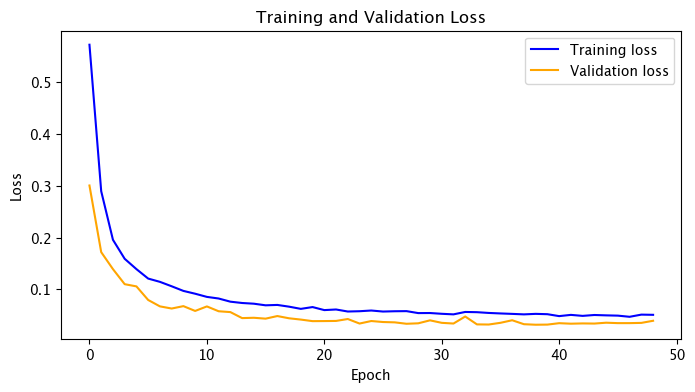

In [22]:
# Plot training history
data_analysis.plot_history(
    train_loss = model.history["loss"], 
    valid_loss = model.history["val_loss"],
    title = "Training and Validation Loss",
    xlabel = "Epoch",
    ylabel = "Loss"
)

### Evaluation

In [23]:
# Disable gradient computation for evaluation
with context_manager.no_grad():
    # Set the model in evaluation mode
    model.eval()
    
    # Compute the predictions
    predictions_norm = model(X_test_norm, batch_size=batch_size, verbose=True)

Processing batch 19/19 - 12.4 ms/stepp

In [24]:
def directional_accuracy(pred: Tensor, true: Tensor) -> float:
    """
    Compute the directional accuracy of predictions.
    
    Parameters:
    - pred: Tensor, predicted values
    - true: Tensor, true values
    
    Returns:
    - float, directional accuracy
    """
    
    # If predicting volatility, check if it increases or decreases
    if predict_volatility:
        # Check if the predicted and true values are increasing or decreasing
        pred_direction = (pred.to_numpy()[1:] > pred.to_numpy()[:-1]).astype(int)
        true_direction = (true.to_numpy()[1:] > true.to_numpy()[:-1]).astype(int)
    else:
        # For log returns, check if the predicted and true values are positive or negative
        pred_direction = (pred.to_numpy() > 0).astype(int)
        true_direction = (true.to_numpy() > 0).astype(int)
    
    # Calculate the directional accuracy
    accuracy = np.mean(pred_direction == true_direction)
    
    # Return the directional accuracy
    return accuracy

In [25]:
# Denormalize the predictions using the target normalization statistics
predictions = denormalization_fn(predictions_norm)

# Compute the mean absolute error on the test set
mae = metrics.mean_absolute_error(predictions, y_test)

# Print the test results
print(f"Test Results:")
print(f"Mean Absolute Error: {mae.to_numpy()}")

# Compute the directional accuracy
dir_acc = directional_accuracy(predictions, y_test)

# Print the directional accuracy
print(f"Directional Accuracy: {dir_acc:.3f}")

Test Results:
Mean Absolute Error: 0.0015480263391509652
Directional Accuracy: 0.890


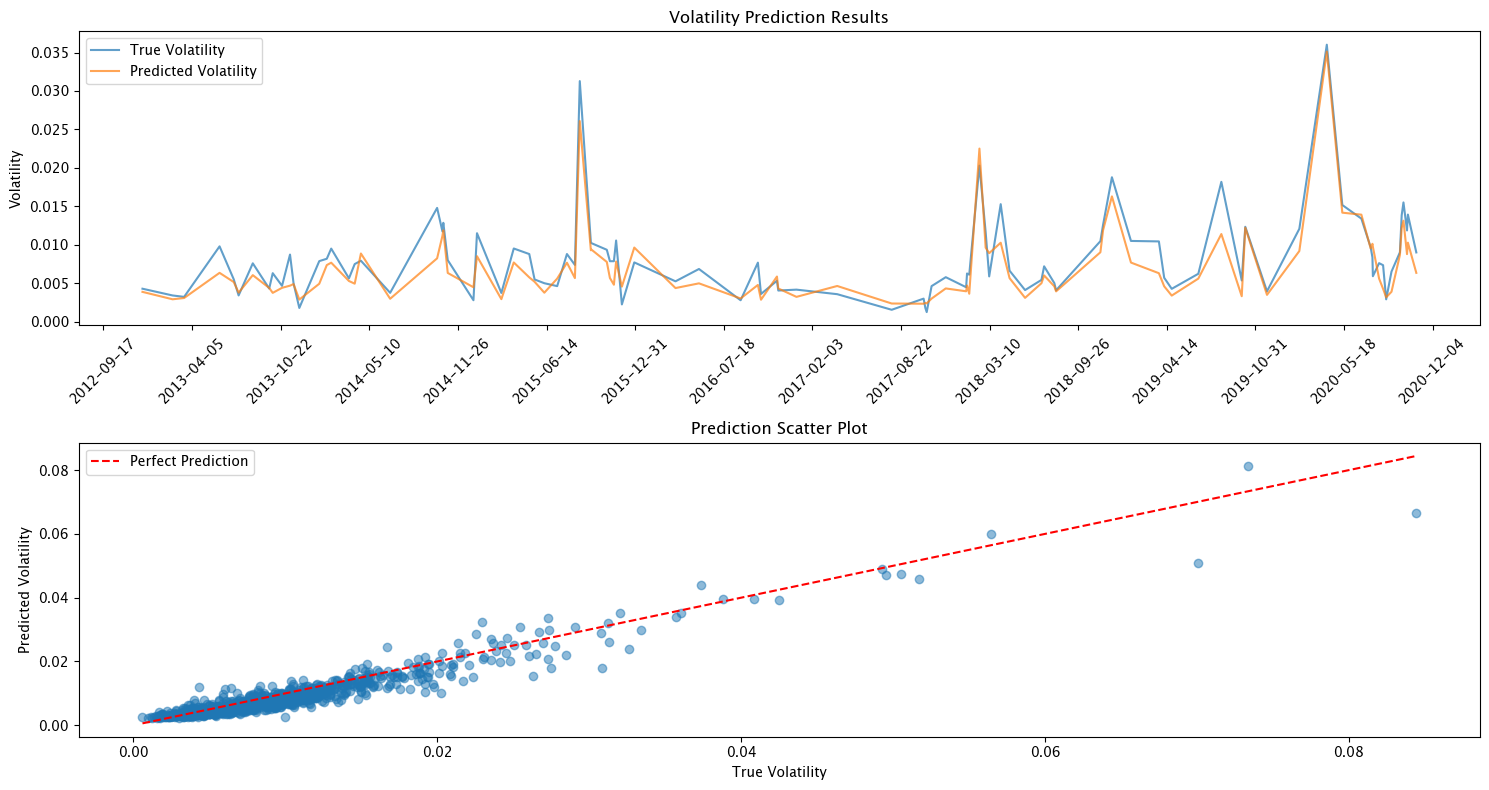

In [26]:
# Prepare the plot object based on whether we are predicting volatility or log returns
plot_obj = "Volatility" if predict_volatility else "Log Returns"
samples_to_plot = 100  # Number of samples to plot

# Sort the test timestamps and corresponding predictions and true values
sorted_indices = np.argsort(test_timestamps.to_numpy())
sorted_test_timestamps = test_timestamps.to_numpy()[sorted_indices]
sorted_y_test = y_test.to_numpy()[sorted_indices]
sorted_predictions = predictions.to_numpy()[sorted_indices]

# Extract the test dates by converting timestamps to datetime
test_dates = np.array([datetime.fromtimestamp(int(t)) for t in sorted_test_timestamps])

# Create a figure for plotting
plt.figure(figsize=(15, 8))

# Plot the time series of true and predicted volatility
plt.subplot(2, 1, 1)
plt.plot(test_dates[-samples_to_plot:], sorted_y_test[-samples_to_plot:, close_price_idx], label=f'True {plot_obj}', alpha=0.7)
plt.plot(test_dates[-samples_to_plot:], sorted_predictions[-samples_to_plot:, close_price_idx], label=f'Predicted {plot_obj}', alpha=0.7)
plt.title(f'{plot_obj} Prediction Results')
plt.ylabel(plot_obj)
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

# Scatter plot of true vs predicted volatility
plt.subplot(2, 1, 2)
plt.scatter(y_test.to_numpy()[:, close_price_idx], predictions.to_numpy()[:, close_price_idx], alpha=0.5)
plt.plot(
    [y_test.to_numpy()[:, close_price_idx].min(), y_test.to_numpy()[:, close_price_idx].max()],
    [y_test.to_numpy()[:, close_price_idx].min(), y_test.to_numpy()[:, close_price_idx].max()],
    'r--', label='Perfect Prediction'
)
plt.xlabel(f'True {plot_obj}')
plt.ylabel(f'Predicted {plot_obj}')
plt.title('Prediction Scatter Plot')
plt.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

### Inference

In [27]:
# Define the number of generation steps
num_generation_steps = 8

# Select the middle index for the test set
test_idx = len(X_test_norm.to_numpy()) // 2

# Take the initial sequence and true continuation for evaluation
initial_seq = X_test_norm[test_idx:test_idx+1]

# Extract the corresponding timestamp for the test index
test_timestamp = test_timestamps[test_idx].to_numpy()

# Find the position of the test index in the sorted timestamps
sorted_test_indices = np.argsort(test_timestamps.to_numpy())
position_in_sorted = np.where(sorted_test_indices == test_idx)[0][0]

# Take the true continuation from the test set
if position_in_sorted + num_generation_steps <= len(sorted_test_indices):
    consecutive_indices = sorted_test_indices[position_in_sorted:position_in_sorted + num_generation_steps]
    true_continuation = y_test[consecutive_indices]
else:
    # If not enough steps are available, adjust the number of generation steps
    available_steps = len(sorted_test_indices) - position_in_sorted
    consecutive_indices = sorted_test_indices[position_in_sorted:position_in_sorted + available_steps]
    true_continuation = y_test[consecutive_indices]
    num_generation_steps = available_steps

# Perform autoregressive prediction
out_seq = model.autoregressive_generation(
    x = initial_seq,
    num_steps = num_generation_steps,
    postprocess_fn = denormalization_fn
)

# Extract the generated sequence if out_seq is a generator
generated_sequence = model.concat_generation(out_seq) if not isinstance(out_seq, Tensor) else out_seq

# Extract the first batch of the generated sequence
generated_sequence = generated_sequence[0]

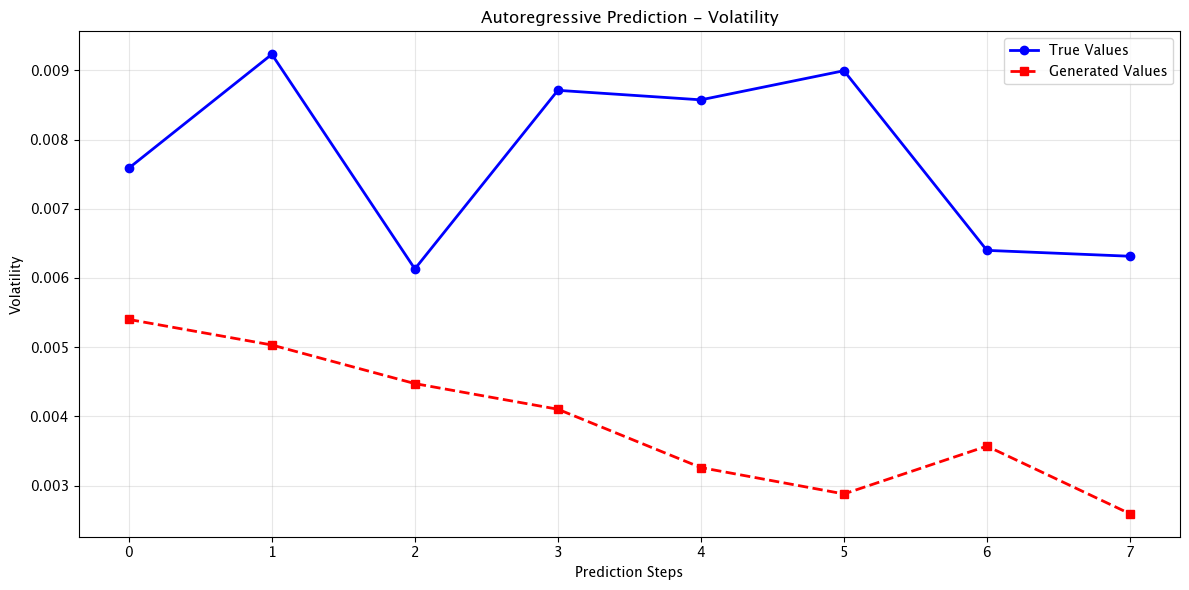

In [28]:
# Plot autoregressive results
plt.figure(figsize=(12, 6))

# Define the steps for plotting
steps = range(num_generation_steps)
feature_idx = close_price_idx

# Plot the true continuation and generated sequence
plt.plot(steps, true_continuation.to_numpy()[:num_generation_steps, close_price_idx], 'b-', label='True Values', linewidth=2, marker='o')
plt.plot(steps, generated_sequence.to_numpy()[:, close_price_idx], 'r--', label='Generated Values', linewidth=2, marker='s')

# Define the plot configurations
plt.title(f'Autoregressive Prediction - {"Volatility" if predict_volatility else "Log Returns"}')
plt.xlabel('Prediction Steps')
plt.ylabel(f'{"Volatility" if predict_volatility else "Log Returns"}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [29]:
# Compute the autoregressive directional accuracy
auto_dir_acc = directional_accuracy(generated_sequence[:, close_price_idx], true_continuation[:, close_price_idx])

# Print the autoregressive directional accuracy
print(f"Autoregressive Directional Accuracy: {auto_dir_acc:.3f}")

Autoregressive Directional Accuracy: 0.429
